In [153]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Пожары в России за 2012-2021 гг. https://data.rcsi.science/data-catalog/datasets/202/#dataset-overview

In [69]:
forrest_fire = pd.read_csv('data/thermopoints.csv', sep= ';')
forrest_fire

,dt,type_name,type_id,lon,lat
0,2012-03-13,Природный пожар,4,131.5866,47.8662
1,2012-03-13,Природный пожар,4,131.5885,47.8809
2,2012-03-13,Лесной пожар,3,131.9871,48.4973
3,2012-03-13,Природный пожар,4,131.9031,43.6277
4,2012-03-13,Природный пожар,4,131.5706,47.8581
...,...,...,...,...,...
660249,2021-09-10,Лесной пожар,3,118.5451,64.7475
660250,2021-09-10,Лесной пожар,3,118.3046,64.7629
660251,2021-09-10,Лесной пожар,3,117.9681,65.7394
660252,2021-09-10,Лесной пожар,3,119.0462,64.7541


Будем рассматривать лесные пожары летом и в сентябре.

In [75]:
forrest_fire = forrest_fire[forrest_fire['type_name'] == 'Лесной пожар' ]
forrest_fire = forrest_fire.drop_duplicates(subset=['dt'])
forrest_fire = forrest_fire[['dt', 'lon', 'lat']]
forrest_fire['dt'] = pd.to_datetime(forrest_fire['dt'])
forrest_fire['month'] = forrest_fire['dt'].dt.month
forrest_fire = forrest_fire[(forrest_fire['month'] < 10) & (forrest_fire['month'] > 5)]
forrest_fire

C:\Users\user\AppData\Local\Temp\ipykernel_1716\1363442291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forrest_fire['dt'] = pd.to_datetime(forrest_fire['dt'])
C:\Users\user\AppData\Local\Temp\ipykernel_1716\1363442291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forrest_fire['month'] = forrest_fire['dt'].dt.month


,dt,lon,lat,month
1897,2012-06-01,66.3320,63.7988,6
1972,2012-06-02,136.7256,60.7618,6
2248,2012-06-03,124.1010,53.6320,6
2362,2012-06-04,140.1607,60.6553,6
2727,2012-06-05,140.2069,58.9203,6
...,...,...,...,...
658692,2021-09-06,121.0165,66.7575,9
659052,2021-09-07,118.8730,64.7312,9
659334,2021-09-08,141.4489,62.9088,9
659674,2021-09-09,122.8659,66.6548,9


Получение погодных данных с помощью api запросов в день пожаров и за 3 дня до него.

In [128]:
#API_KEY = 'JGB3E6K8CNPVWWLSFBF5XKFNL'
#API_KEY = '7TM5XPHE3AMUHWQ3XPVHXL4EL'
#API_KEY = 'VQ959KJETGEP22HECX5R3CPQQ' 
API_KEY = 'MS77XFUHC76YM9C9UUG5KF72W'
def fetch_weather(row):
    dt, lon, lat = row['dt'], row['lon'], row['lat']
    
    dates = [(dt - timedelta(days=i)).strftime("%Y-%m-%d") for i in range(3, -1, -1)]
    
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{lat},{lon}/{dates[0]}/{dates[-1]}"
    params = {
        "key": API_KEY,
        "include": "days",
        "elements": "datetime,tempmax,humidity,windspeed,precipcover"
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        days_data = response.json().get("days", [])

        rows = []
        for day in days_data:
            rows.append({
                "dt": day["datetime"],  
                "lat": lat,
                "lon": lon,
                "temp": round((day["tempmax"] - 32) * 5 / 9, 1),  
                "humidity": day["humidity"],
                "windspeed": round(day["windspeed"] * 1.6, 1),  
                "precipcover": day["precipcover"]
            })
        
        return pd.DataFrame(rows)
    else:
        print(f"⚠️ Ошибка запроса для dt {dt}: статус {response.status_code}")
        return pd.DataFrame()  

locations_df = forrest_fire.iloc

result_list = []
for index, row in locations_df.iterrows():
    df_weather = fetch_weather(row)
    result_list.append(df_weather)

firecast_df = pd.concat(result_list, ignore_index=True)

Создание признака пожара (fire) 1 - был пожар, 0 - не было.

In [129]:
firecast_df['fire'] = (firecast_df.index % 4 == 3).astype(int)
firecast_df.head(12)

,dt,lat,lon,temp,humidity,windspeed,precipcover,fire
0,2019-06-28,65.9391,141.8427,18.1,42.5,13.9,0.00,0
1,2019-06-29,65.9391,141.8427,18.7,42.5,12.2,0.00,0
2,2019-06-30,65.9391,141.8427,15.2,47.0,12.2,0.00,0
3,2019-07-01,65.9391,141.8427,20.2,47.0,7.5,0.00,1
4,2019-06-29,64.4163,130.4632,28.8,58.4,14.7,4.17,0
5,2019-06-30,64.4163,130.4632,23.3,57.6,25.1,0.00,0
6,2019-07-01,64.4163,130.4632,25.7,52.2,21.4,4.17,0
7,2019-07-02,64.4163,130.4632,23.3,73.9,15.7,8.33,1
8,2019-06-30,53.0038,136.7677,28.0,63.5,9.0,4.17,0
9,2019-07-01,53.0038,136.7677,25.5,66.3,13.0,4.17,0


Получение регионов с помощью api запросов. https://docs.locationiq.com/


In [130]:
REGION_API_KEY = 'pk.75bd506ce93aed96139f28e16410fcb9'
#REGION_API_KEY = 'pk.b31768339c26465ba31eb25fcc8a1db9 '
def getRegion(row):

    lon, lat =  row['lon'], row['lat']

    url = f"https://us1.locationiq.com/v1/reverse?key={REGION_API_KEY}&lat={lat}&lon={lon}&format=json"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        region = data['address'].get('region', None)
    else:
        print(f"Ошибка {response.status_code}: {response.text}")
        region = None

    time.sleep(1)

    return region

firecast_df['region'] = firecast_df.apply(getRegion, axis= 1)
firecast_df

,dt,lat,lon,temp,humidity,windspeed,precipcover,fire,region
0,2019-06-28,65.9391,141.8427,18.1,42.5,13.9,0.00,0,Far Eastern Federal District
1,2019-06-29,65.9391,141.8427,18.7,42.5,12.2,0.00,0,Far Eastern Federal District
2,2019-06-30,65.9391,141.8427,15.2,47.0,12.2,0.00,0,Far Eastern Federal District
3,2019-07-01,65.9391,141.8427,20.2,47.0,7.5,0.00,1,Far Eastern Federal District
4,2019-06-29,64.4163,130.4632,28.8,58.4,14.7,4.17,0,Far Eastern Federal District
...,...,...,...,...,...,...,...,...,...
995,2021-07-16,60.9660,28.7680,26.8,65.0,22.2,0.00,1,Northwestern Federal District
996,2021-07-14,60.9917,30.0575,31.2,60.6,14.2,0.00,0,Northwestern Federal District
997,2021-07-15,60.9917,30.0575,31.6,65.7,19.8,4.17,0,Northwestern Federal District
998,2021-07-16,60.9917,30.0575,28.2,64.3,21.4,0.00,0,Northwestern Federal District


Преобразование столбца dt в тип datetime и добавляем три столбца year, month, day.

In [133]:
firecast_df['dt'] = pd.to_datetime(firecast_df['dt'])
firecast_df['year'] = firecast_df['dt'].dt.year
firecast_df['month'] = firecast_df['dt'].dt.month
firecast_df['day'] = firecast_df['dt'].dt.day
firecast_df['dt']

0      2016-08-15
1      2016-08-16
2      2016-08-17
3      2016-08-18
4      2016-08-16
          ...    
3953   2016-08-16
3954   2016-08-14
3955   2016-08-15
3956   2016-08-16
3957   2016-08-17
Name: dt, Length: 3958, dtype: datetime64[ns]

Просмотр регионов в таблице.

In [137]:
firecast_df['region'].value_counts()

region
Far Eastern Federal District     3221
Siberian Federal District         620
Northwestern Federal District      52
Ural Federal District              45
Central Federal District           12
Volga Federal District              8
Name: count, dtype: int64

Кодировка регионов для модели.

In [144]:
regions_code = {'Far Eastern Federal District': 1,
                'Siberian Federal District': 2,
                'Ural Federal District': 3,
                'Volga Federal District': 4,
                'Central Federal District': 5,
                'Northwestern Federal District': 6,}

def codingRegion(x):
    return regions_code[x]

firecast_df['region_code'] = firecast_df['region'].apply(codingRegion)
firecast_df.head(12)

,dt,lat,lon,temp,humidity,windspeed,precipcover,fire,region,year,month,day,region_code
0,2016-08-15,56.2720,112.2769,24.1,66.1,5.4,0.00,0,Far Eastern Federal District,2016,8,15,1
1,2016-08-16,56.2720,112.2769,22.6,64.5,9.0,0.00,0,Far Eastern Federal District,2016,8,16,1
2,2016-08-17,56.2720,112.2769,22.7,63.1,6.1,0.00,0,Far Eastern Federal District,2016,8,17,1
3,2016-08-18,56.2720,112.2769,22.7,64.6,4.0,0.00,1,Far Eastern Federal District,2016,8,18,1
4,2016-08-16,57.5833,106.8849,26.8,65.1,13.0,0.00,0,Siberian Federal District,2016,8,16,2
5,2016-08-17,57.5833,106.8849,27.8,63.9,8.2,0.00,0,Siberian Federal District,2016,8,17,2
6,2016-08-18,57.5833,106.8849,24.8,72.7,8.2,4.17,0,Siberian Federal District,2016,8,18,2
7,2016-08-19,57.5833,106.8849,23.2,70.4,14.2,0.00,1,Siberian Federal District,2016,8,19,2
8,2016-08-17,61.0740,170.4527,20.8,69.6,16.5,0.00,0,Far Eastern Federal District,2016,8,17,1
9,2016-08-18,61.0740,170.4527,12.7,88.3,9.0,41.67,0,Far Eastern Federal District,2016,8,18,1


Построим гистрограмму и коробчатую диаграмму для признака temp - температура (C).

Text(0.5, 1.0, 'Temp Boxplot')

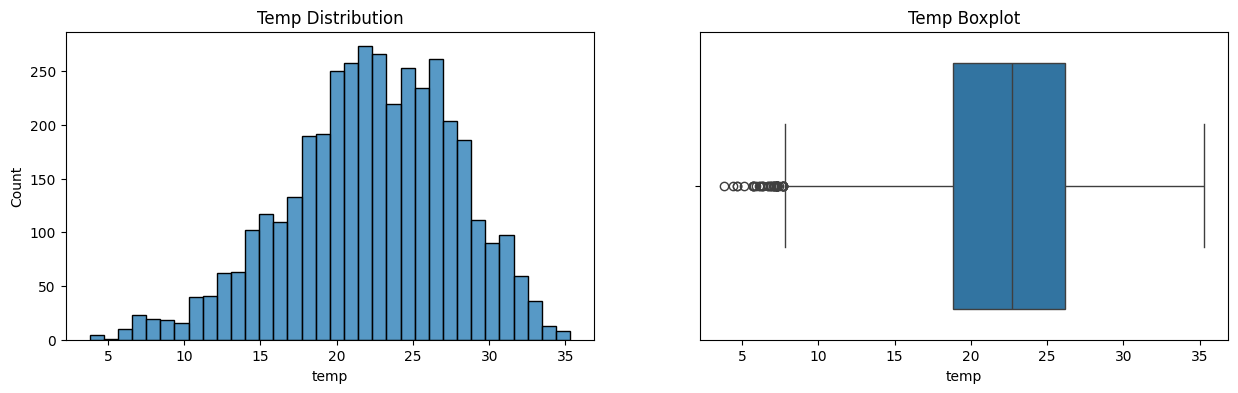

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=firecast_df, x='temp', ax=axes[0])
histplot.set_title('Temp Distribution')
boxplot = sns.boxplot(data=firecast_df, x='temp', ax=axes[1])
boxplot.set_title('Temp Boxplot')

Метод межквартильного размаха.

In [145]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [146]:
outliers, cleaned = outliers_iqr(firecast_df, 'temp')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 44
Результирующее число записей: 3914


Графики после очистки методом межквартильного размаха.

Text(0.5, 1.0, 'Cleaned Temp Boxplot')

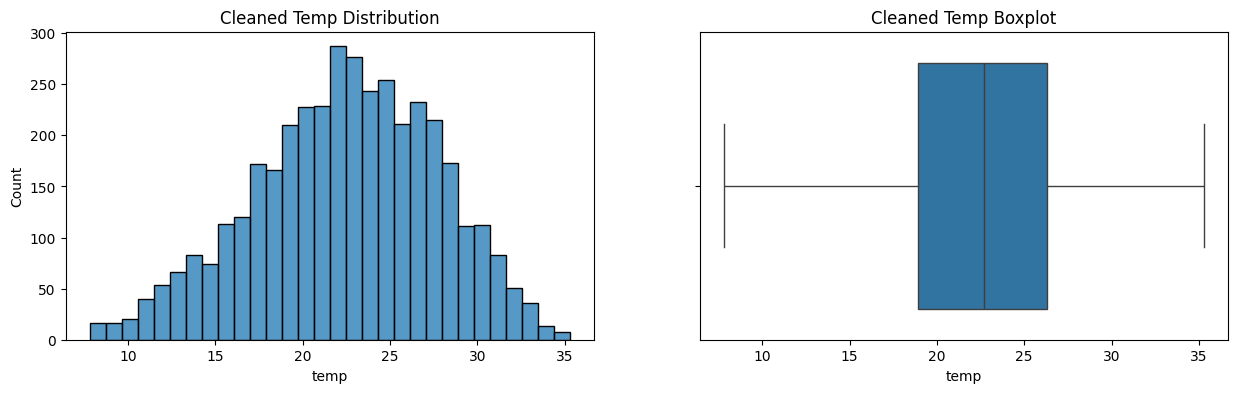

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='temp', ax=axes[0])
histplot.set_title('Cleaned Temp Distribution')
boxplot = sns.boxplot(data=cleaned, x='temp', ax=axes[1])
boxplot.set_title('Cleaned Temp Boxplot')

Построим гистрограмму и коробчатую диаграмму для признака humidity - относительная влажность (%).

Text(0.5, 1.0, 'Humidity Boxplot')

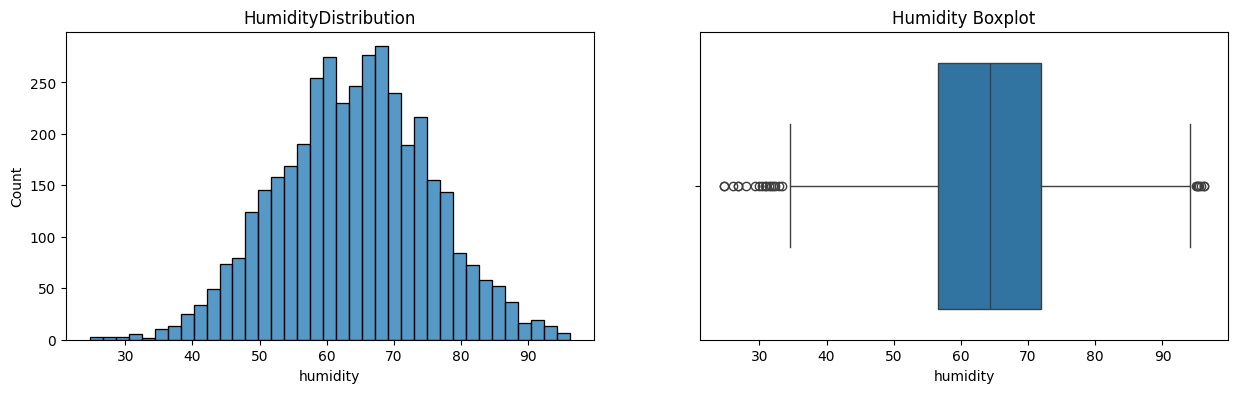

In [148]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=firecast_df, x='humidity', ax=axes[0])
histplot.set_title('HumidityDistribution')
boxplot = sns.boxplot(data=firecast_df, x='humidity', ax=axes[1])
boxplot.set_title('Humidity Boxplot')

In [149]:
outliers, cleaned = outliers_iqr(cleaned, 'humidity')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 24
Результирующее число записей: 3890


Графики после очистки методом межквартильного размаха.

Text(0.5, 1.0, 'Cleaned Humidity Boxplot')

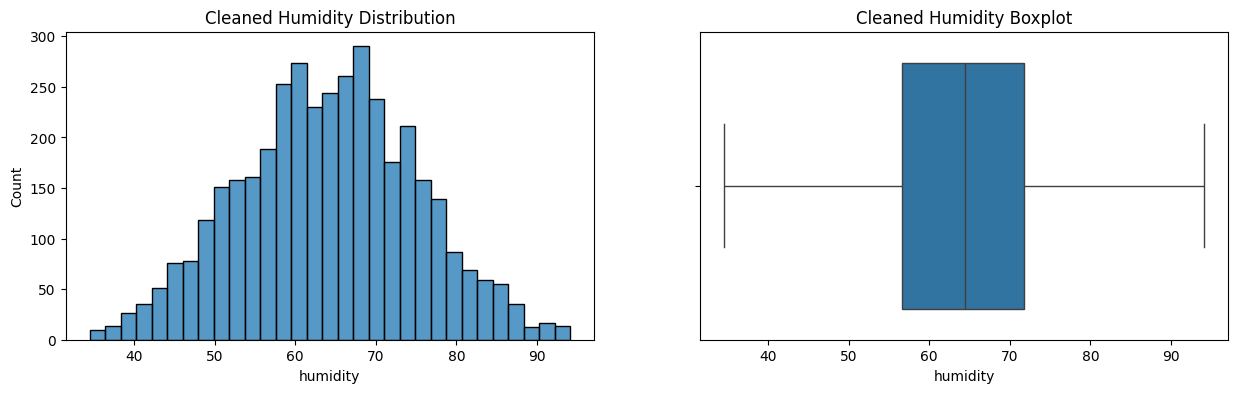

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='humidity', ax=axes[0])
histplot.set_title('Cleaned Humidity Distribution')
boxplot = sns.boxplot(data=cleaned, x='humidity', ax=axes[1])
boxplot.set_title('Cleaned Humidity Boxplot')

In [121]:
# compression_opts = dict(method='zip', archive_name='out.csv') 
# cleaned.to_csv('data/out.zip', index=False, compression=compression_opts)

In [151]:
cleaned

,dt,lat,lon,temp,humidity,windspeed,precipcover,fire,region,year,month,day,region_code
0,2016-08-15,56.2720,112.2769,24.1,66.1,5.4,0.00,0,Far Eastern Federal District,2016,8,15,1
1,2016-08-16,56.2720,112.2769,22.6,64.5,9.0,0.00,0,Far Eastern Federal District,2016,8,16,1
2,2016-08-17,56.2720,112.2769,22.7,63.1,6.1,0.00,0,Far Eastern Federal District,2016,8,17,1
3,2016-08-18,56.2720,112.2769,22.7,64.6,4.0,0.00,1,Far Eastern Federal District,2016,8,18,1
4,2016-08-16,57.5833,106.8849,26.8,65.1,13.0,0.00,0,Siberian Federal District,2016,8,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,2016-08-16,62.8190,152.7259,24.6,62.2,11.5,0.00,1,Far Eastern Federal District,2016,8,16,1
3954,2016-08-14,61.4165,168.2530,14.9,78.4,12.5,16.67,0,Far Eastern Federal District,2016,8,14,1
3955,2016-08-15,61.4165,168.2530,18.4,73.0,13.9,4.17,0,Far Eastern Federal District,2016,8,15,1
3956,2016-08-16,61.4165,168.2530,19.9,69.7,5.0,0.00,0,Far Eastern Federal District,2016,8,16,1


Построим две гистограммы для признака windspeed - скрость ветра (км/ч), первая — в обычном масштабе, а вторая — в логарифмическом.

Text(0.5, 1.0, 'Log Windspeed Distribution')

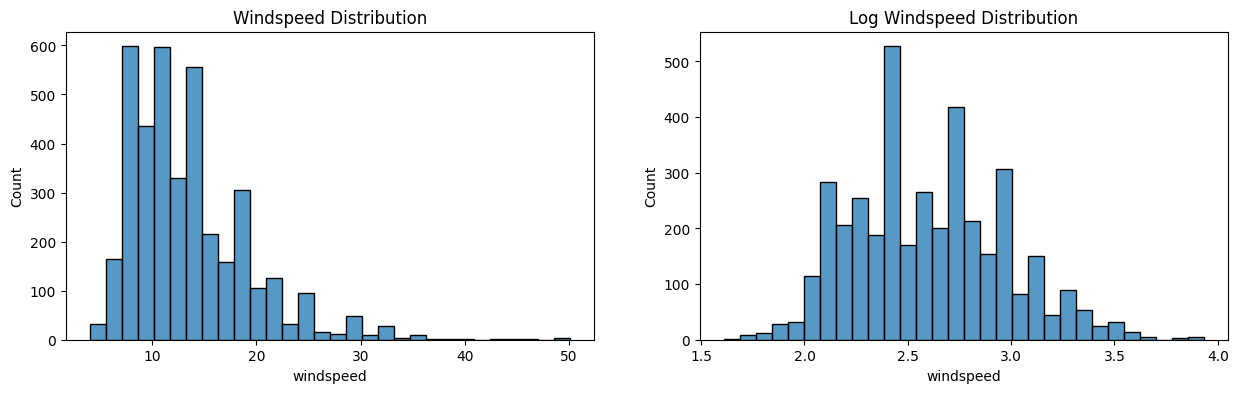

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
histplot = sns.histplot(cleaned['windspeed'], bins=30, ax=axes[0])
histplot.set_title('Windspeed Distribution')

log_mkad_km= np.log(cleaned['windspeed'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log Windspeed Distribution')

Метод z-отклонений.

In [160]:
def outliers_z_score_mod(data, feature, log_scale=False, left= 3, right= 3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

Text(0.5, 1.0, 'Log Windspeed Distribution')

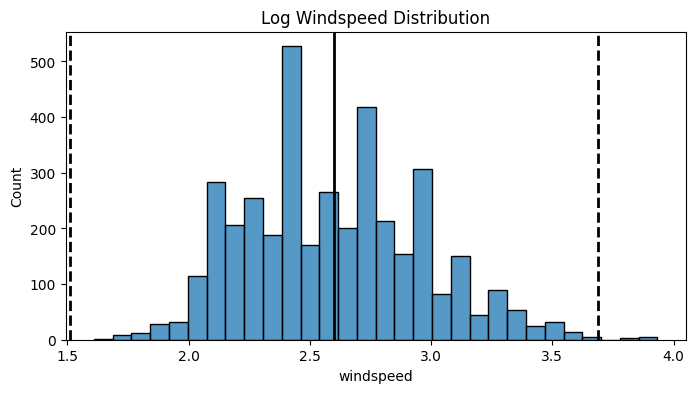

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(cleaned['windspeed'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log Windspeed Distribution')

In [164]:
outliers, cleaned = outliers_z_score_mod(cleaned, 'windspeed', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 10
Результирующее число записей: 3880


График после очистки методом межквартильного размаха.

Text(0.5, 1.0, 'Cleaned Windspeed Distribution')

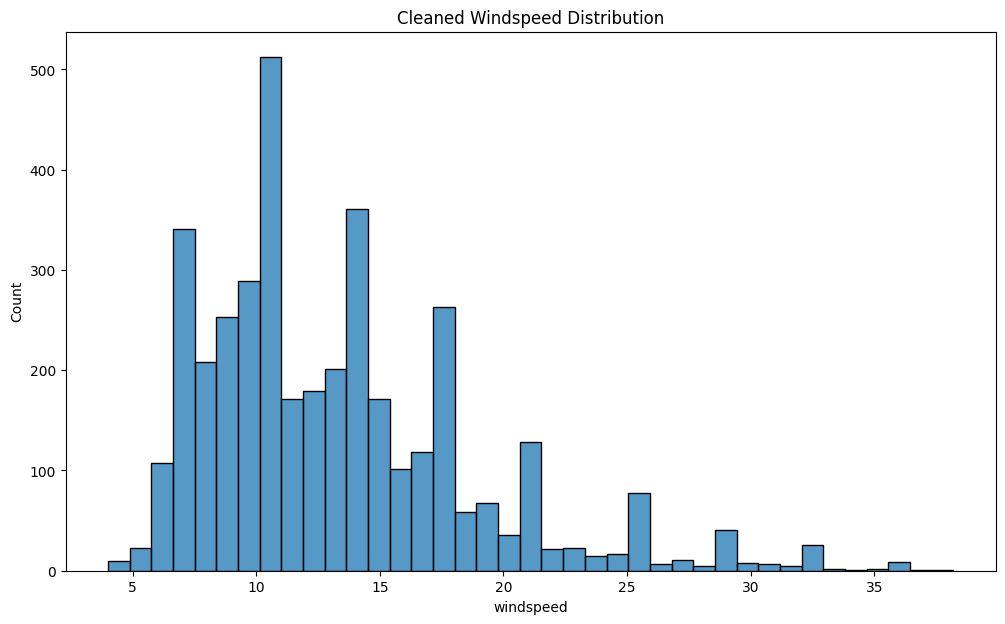

In [169]:
fig = plt.subplots(figsize=(12, 7))
histplot = sns.histplot(data=cleaned, x='windspeed')
histplot.set_title('Cleaned Windspeed Distribution')

Оставим только необходимые признаки, сбросим индексы и запишем df их в csv файл.

In [ ]:
cleaned = cleaned.drop(columns= ['dt', 'region', 'lat', 'lon'])

In [185]:
cleaned = cleaned.reset_index()

In [186]:
compression_opts = dict(method='zip', archive_name='dataset.csv') 
cleaned.to_csv('data/dataset.zip', index=False, compression=compression_opts)